In [20]:
import keras
import scipy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


In [21]:
train_path = './dataset/train'
valid_path = './dataset/valid/'

In [22]:
# hiển thị hình ảnh tăng cường
def PlotImage(img_arr):
  fig,axes = plt.subplots(1,5,figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(img_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()
  

In [23]:
#
training_datagen = ImageDataGenerator( 
    rescale=1/255 ,
    rotation_range=40 , #Xoay ảnh góc tối đa là 40 độ
    width_shift_range=0.2 , #Dịch theo chiều ngang ngẫu nhiên trong một phạm vi nào đó
    height_shift_range=0.2 , #Dịch theo chiều dọc ngẫu nhiên trong một phạm vi nào đó
    shear_range=0.2 , #Làm méo ảnh
    zoom_range=0.2 , #thực hiện zoom ngẫu nhiên trong một phạm vi nào đó
    horizontal_flip=True , # Lật ngẫu nhiên các đầu vào theo chiều ngang.
    # fill_mode='nearest'
     )

training_data= training_datagen.flow_from_directory(train_path , target_size=(200,200) , batch_size=128 , class_mode='binary' )
#batch_size : Số lượng ảnh được yielded từ generator cho mỗi lô batch.
#class_mode: set "binary" nếu bạn có 2 classes để dự đoán, nếu không thì bạn set "categorical"

Found 3153 images belonging to 2 classes.


In [24]:
training_data.class_indices

{'with_mask': 0, 'without_mask': 1}

In [25]:
valid_datagen = ImageDataGenerator( rescale=1/255)
valid_data= training_datagen.flow_from_directory(valid_path , target_size=(200,200) , batch_size=128 , class_mode='binary' )

Found 898 images belonging to 2 classes.


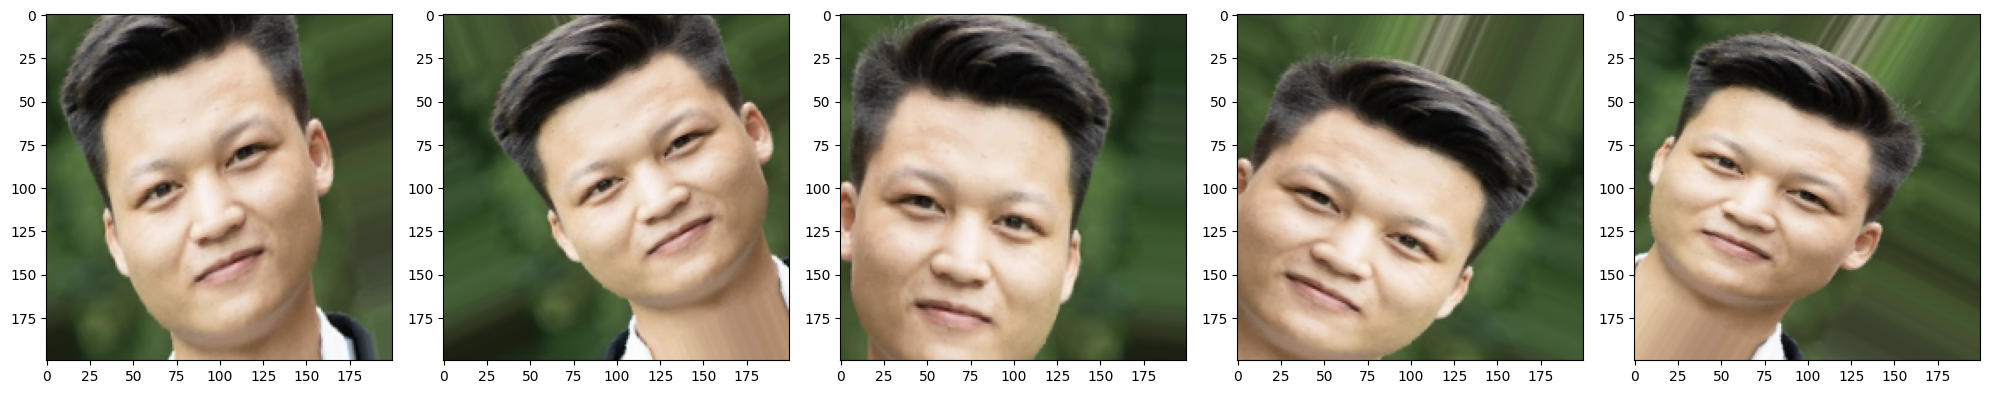

In [26]:
# print('scipy', scipy)
images = [ training_data[0][0][0] for i in range(5) ]
PlotImage(images)


In [27]:
model_save_path = 'face_mask_detection_model.h5'
#Lưu checkpoint (Lưu lại weights( hoặc model) của model tại một thời điểm nào đó  (gọi là checkpoint))
#  sử dụng lệnh callbacks để xem trạng thái bên trong và số liệu thống kê của mô hình trong quá trình đào tạo.
# lưu lại các trạng thái và thông số của model trong quá trình training.
#monitor: tham số quan sát
#verbose: verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
#save_best_only: Nếu để là true thì model chỉ lưu lại một checkpoint tốt nhất và ngược lại
#mode: là chế độ xem xét tham số quan sát. Nếu để là “min” thì tham số quan sát càng giảm càng “khá” (ví dụ loss), nếu để là “max” thì tham số quan sát càng tăng càng “khá” (ví dụ accuracy). Nếu để “auto” là ngon lành nhất, mode sẽ tự chuyển thành min hoặc max tuỳ vào tham số của chúng ta là loss hay accuracy.
checkpoint = ModelCheckpoint(model_save_path , monitor='val_accuracy' ,verbose=1 , save_best_only=True , mode='max')
callbacks_list = [checkpoint]

In [28]:
#Một Sequential mô hình thích hợp cho một chồng lớp tuyến tính trong đó mỗi lớp có chính xác một tensor đầu vào và một tensor đầu ra .
#( add tuần tự các layer-lớp vào nhau)
model = keras.models.Sequential([
#Tạo Convolutionnal Layers : Conv2D là convolution dùng để lấy feature từ ảnh với các tham số :
#kernel_size :kích thước window search trên ảnh,xác định chiều cao và chiều rộng của cửa sổ tích chập 2D. Có thể là một số nguyên duy nhất để chỉ định cùng một giá trị cho tất cả các kích thước không gian
#filters : số filter của convolution
#imput_shape là đầu vào hình ảnh 200x200 pixel ở RGB (ảnh màu)
#pool_size : số nguyên hoặc bộ của 2 số nguyên, kích thước cửa sổ lấy giá trị lớn nhất. (2, 2)sẽ nhận giá trị tối đa trên cửa sổ gộp 2x2. Nếu chỉ một số nguyên được chỉ định, độ dài cửa sổ giống nhau sẽ được sử dụng cho cả hai thứ nguyên.

                                    keras.layers.Conv2D(filters=32, kernel_size=3, input_shape=[200, 200, 3]),
#Maxpooling : giữ lại chi tiết quan trọng hay giữ lại pixel có giá trị lớn nhất 
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Conv2D(filters=64, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Conv2D(filters=128, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),                                    
                                    keras.layers.Conv2D(filters=256, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),

 #Flatten : Làm phẳng đầu vào. Không ảnh hưởng đến kích thước lô.                                                                         
                                    keras.layers.Flatten(), # neural network beulding
                                    #Dense: là 1 layer chứa : units : số chiều không gian đầu ra , hàm relu : là hàm phi khử tuyến tính để hàm hđ tốt hơn 
                                    keras.layers.Dense(units=128, activation='relu'), # input layers
#Dropout là cách thức mà chúng ta giả định một phần các unit bị bỏ đi trong quá trình training, để tránh overfitting
                                    keras.layers.Dropout(0.1),                                    
                                    keras.layers.Dense(units=256, activation='relu'),                                    
                                    keras.layers.Dropout(0.25),                               
#hàm softmax:hàm trung bình mũ,tính toán xác suất xảy ra của một sự kiện.hàm softmax sẽ tính khả năng xuất hiện của một class trong tổng số tất cả các class có thể xuất hiện
                                    keras.layers.Dense(units=2, activation='softmax') # output layer
])

In [29]:
#Compile model
#Bạn có thể khởi tạo trình tối ưu hóa trước khi chuyển nó tới model.compile (),các tham số mặc định cho trình tối ưu hóa sẽ được sử dụng.
#optimizer : thuật toán tối ưu mục đích "học " được các features ( hay pattern) của dữ liệu đầu vào, từ đó có thể tìm 1 cặp weights và bias phù hợp để tối ưu hóa model
#optimizer Adam là một phương pháp giảm độ dốc ngẫu nhiên dựa trên ước tính thích ứng của các khoảnh khắc bậc nhất và bậc hai.
#metrics=['accuracy']  sử dụng để đánh giá hiệu suất của mô hình của bạn.
#Hàm loss : sparse_categorical_accuracykiểm tra xem giá trị thực tối đa có bằng với chỉ số của giá trị dự đoán tối đa hay không.
model.compile(optimizer= 'adam' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

In [30]:
#Summary () để in một bản tóm tắt hữu ích về mô hình, bao gồm: Tên và kiểu của tất cả các lớp trong mô hình. Hình dạng đầu ra cho mỗi lớp
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 128)     

In [31]:
#Train model 
#epochs là số vòng train , sô lần duyệt qua tất cả phần tử tập train
history = model.fit(training_data ,
                    epochs=50 , 
                    verbose=1, 
                    validation_data= valid_data , 
                    callbacks = callbacks_list )

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.0026 - accuracy: 0.6115
Epoch 1: val_accuracy improved from -inf to 0.73831, saving model to face_mask_detection_model.h5
25/25 [==============================] - 96s 4s/step - loss: 1.0026 - accuracy: 0.6115 - val_loss: 0.5428 - val_accuracy: 0.7383
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.4140 - accuracy: 0.8313
Epoch 2: val_accuracy improved from 0.73831 to 0.82739, saving model to face_mask_detection_model.h5
25/25 [==============================] - 89s 4s/step - loss: 0.4140 - accuracy: 0.8313 - val_loss: 0.4440 - val_accuracy: 0.8274
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.3220 - accuracy: 0.8785
Epoch 3: val_accuracy improved from 0.82739 to 0.86303, saving model to face_mask_detection_model.h5
25/25 [==============================] - 92s 4s/step - loss: 0.3220 - accuracy: 0.8785 - val_loss: 0.3728 - val_accuracy: 0.8630
Epoch 4/50
25/25 [=============

In [33]:
model.save("new_improved_model_ver2.h5")

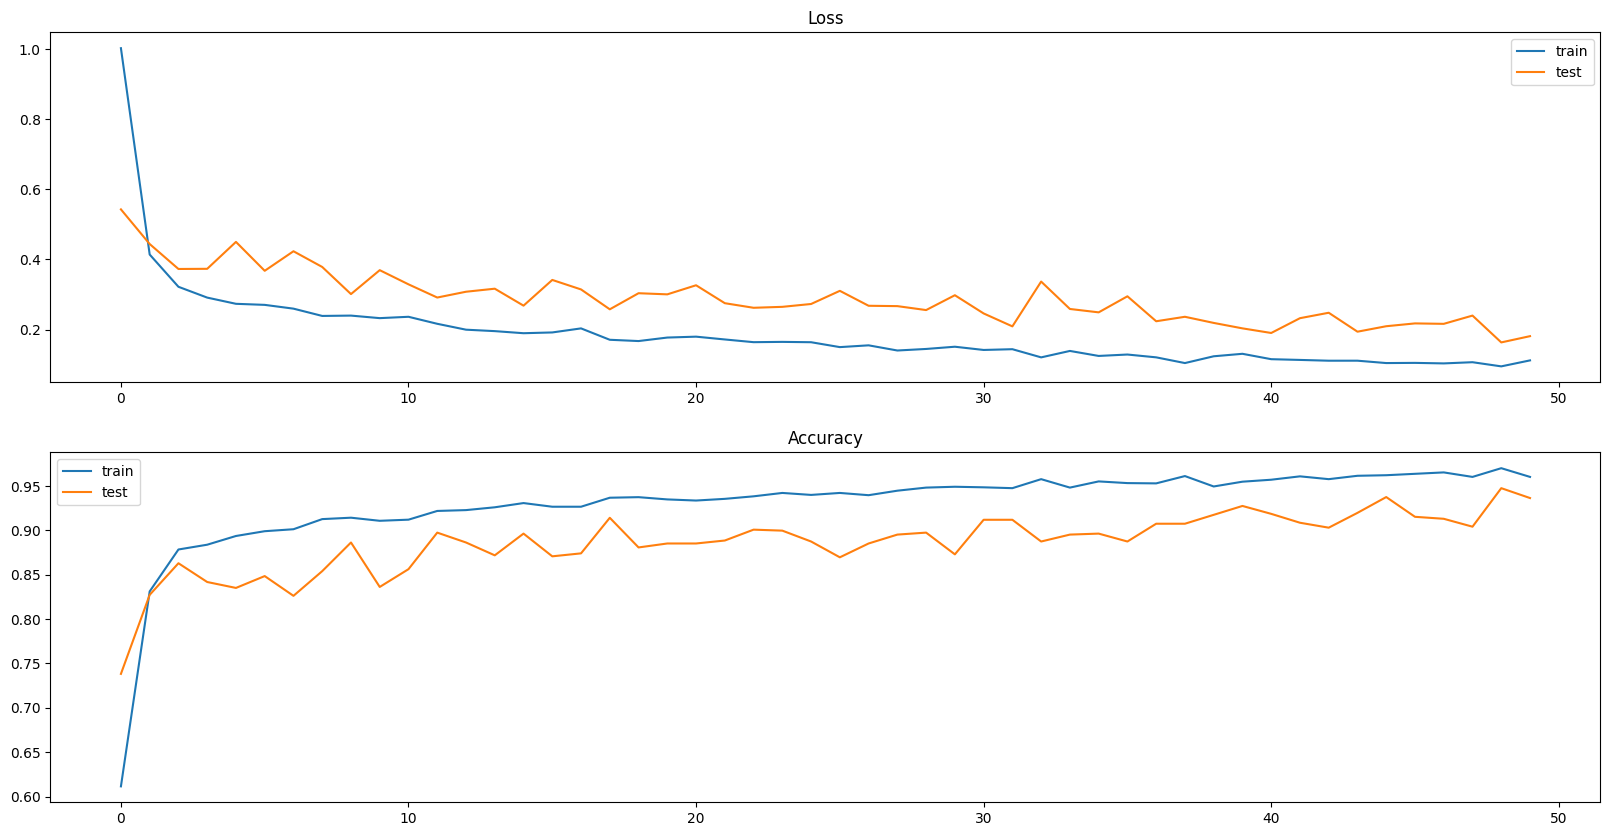

In [32]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
